In [1]:
from fastai.basics import *
from fastai.callback.schedule import fit_one_cycle
from fastai.callback.hook import summary
from fastai.callback.tracker import SaveModelCallback
from fastai.data.load import DataLoader as FDataLoader
from torch.utils.data import *

from traffic_dataset import *
from model import *

# Initialise Training and Validation DataLoaders

In [2]:
data_folder = '../storage/'
city = 'MOSCOW'
bs = 4
time_step = 24

train = TrafficDataset(data_folder = data_folder, city=city, partition='training2', time_step=time_step, bs=bs)
valid = TrafficDataset(data_folder = data_folder, city=city, partition='validation2', time_step=24, bs=bs)
train_dl = FDataLoader(dataset=train,
                       bs=None,
                       num_workers=bs,
                       pin_memory=True,
                       shuffle=True,
                       device=torch.device('cuda'))
valid_dl = FDataLoader(dataset=valid,
                       bs=None,
                       num_workers=bs,
                       pin_memory=True,
                       shuffle=True,
                       device=torch.device('cuda'))

data = DataLoaders(train_dl, valid_dl, device=torch.device('cuda'))

In [3]:
len(train_dl), len(valid_dl)

(499, 49)

In [4]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([4, 116, 495, 436]), torch.Size([4, 8, 12, 495, 436]))

# Define Leaderboard Score

Model is predicting 12 frames in 5-minute intervals, while leaderboard only takes into account 6 of the 12 frames, hence excess frames need to be discarded when calculating the leaderboard score.

In [5]:
# pred.shape = (Batch Size, Channels, Time, Height, Width)
# When calculating the score, only frames 0,1,2,5,8,11 are considered, these frames correspond to 5,10,15,30,45,60 minutes
def leaderboard(pred, label):
    pred = torch.floor(pred)
    return F.mse_loss(pred[...,[0,1,2,5,8,11],:,:], label[...,[0,1,2,5,8,11],:,:])

# Initialise Model

In [6]:
learn = Learner(data, NetO().cuda(), loss_func=nn.MSELoss(), metrics=leaderboard)

# Print Model Summary

In [7]:
learn.summary()

NetO (Input shape: ['4 x 116 x 495 x 436'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               4 x 64 x 495 x 436   82,432     True      
________________________________________________________________
ELU                  4 x 64 x 495 x 436   0          False     
________________________________________________________________
GroupNorm            4 x 64 x 495 x 436   128        True      
________________________________________________________________
Conv2d               4 x 64 x 495 x 436   119,296    True      
________________________________________________________________
ELU                  4 x 64 x 495 x 436   0          False     
________________________________________________________________
GroupNorm            4 x 64 x 495 x 436   128        True      
________________________________________________________________
Conv2d               4 x 64 x 495 x 436   156,160    True      
______________________________________________________

# Find Suitable Learning Rate

Minimum/10: 3.31e-01, steepest point: 2.29e-04


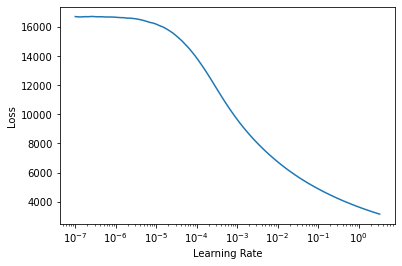

In [8]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

# Run Training Cycles

In [ ]:
learn.fit_one_cycle(7, lr_max=3e-4)

In [ ]:
learn.save('moscow_o007')

Run more cycles until leaderboard score no longer improves.